In [5]:
import tensorflow as tf

# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# Configure TensorFlow to use the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')


if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

GPU found
1 Physical GPUs, 1 Logical GPUs


In [6]:
import cv2
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from transformers import AutoImageProcessor, TFViTModel
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense,Flatten


# Load the dataset directory path
# data_dir = "M:/Datasets/aloi_ill/png"  # Update this to your dataset path
data_dir = "M:\SIFT\small_data"  # Update this to your dataset path

image_paths = []
labels = []

# Load images and assign labels based on folder names
for label in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, label)
    if os.path.isdir(class_dir):
        for file in os.listdir(class_dir):
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, file))
                labels.append(int(label))  # Convert folder name to integer label



print(image_paths)
print(len(labels))

print(len(image_paths))






['M:\\SIFT\\small_data\\1\\1_l1c1.png', 'M:\\SIFT\\small_data\\1\\1_l1c2.png', 'M:\\SIFT\\small_data\\1\\1_l1c3.png', 'M:\\SIFT\\small_data\\1\\1_l2c1.png', 'M:\\SIFT\\small_data\\1\\1_l2c2.png', 'M:\\SIFT\\small_data\\1\\1_l2c3.png', 'M:\\SIFT\\small_data\\1\\1_l3c1.png', 'M:\\SIFT\\small_data\\1\\1_l3c2.png', 'M:\\SIFT\\small_data\\1\\1_l3c3.png', 'M:\\SIFT\\small_data\\1\\1_l4c1.png', 'M:\\SIFT\\small_data\\1\\1_l4c2.png', 'M:\\SIFT\\small_data\\1\\1_l4c3.png', 'M:\\SIFT\\small_data\\1\\1_l5c1.png', 'M:\\SIFT\\small_data\\1\\1_l5c2.png', 'M:\\SIFT\\small_data\\1\\1_l5c3.png', 'M:\\SIFT\\small_data\\1\\1_l6c1.png', 'M:\\SIFT\\small_data\\1\\1_l6c2.png', 'M:\\SIFT\\small_data\\1\\1_l6c3.png', 'M:\\SIFT\\small_data\\1\\1_l7c1.png', 'M:\\SIFT\\small_data\\1\\1_l7c2.png', 'M:\\SIFT\\small_data\\1\\1_l7c3.png', 'M:\\SIFT\\small_data\\1\\1_l8c1.png', 'M:\\SIFT\\small_data\\1\\1_l8c2.png', 'M:\\SIFT\\small_data\\1\\1_l8c3.png', 'M:\\SIFT\\small_data\\10\\10_l1c1.png', 'M:\\SIFT\\small_data\

In [7]:
# Step 1: Load EfficientNet model
base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
# model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
base_model.trainable = False
# print(base_model.summary())
inputs=Input(shape=(3,224, 224), name='pixel_values', dtype='float32')
output=base_model(inputs).last_hidden_state
model = Model(inputs=inputs,outputs=output)


All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [8]:
image_paths

['M:\\SIFT\\small_data\\1\\1_l1c1.png',
 'M:\\SIFT\\small_data\\1\\1_l1c2.png',
 'M:\\SIFT\\small_data\\1\\1_l1c3.png',
 'M:\\SIFT\\small_data\\1\\1_l2c1.png',
 'M:\\SIFT\\small_data\\1\\1_l2c2.png',
 'M:\\SIFT\\small_data\\1\\1_l2c3.png',
 'M:\\SIFT\\small_data\\1\\1_l3c1.png',
 'M:\\SIFT\\small_data\\1\\1_l3c2.png',
 'M:\\SIFT\\small_data\\1\\1_l3c3.png',
 'M:\\SIFT\\small_data\\1\\1_l4c1.png',
 'M:\\SIFT\\small_data\\1\\1_l4c2.png',
 'M:\\SIFT\\small_data\\1\\1_l4c3.png',
 'M:\\SIFT\\small_data\\1\\1_l5c1.png',
 'M:\\SIFT\\small_data\\1\\1_l5c2.png',
 'M:\\SIFT\\small_data\\1\\1_l5c3.png',
 'M:\\SIFT\\small_data\\1\\1_l6c1.png',
 'M:\\SIFT\\small_data\\1\\1_l6c2.png',
 'M:\\SIFT\\small_data\\1\\1_l6c3.png',
 'M:\\SIFT\\small_data\\1\\1_l7c1.png',
 'M:\\SIFT\\small_data\\1\\1_l7c2.png',
 'M:\\SIFT\\small_data\\1\\1_l7c3.png',
 'M:\\SIFT\\small_data\\1\\1_l8c1.png',
 'M:\\SIFT\\small_data\\1\\1_l8c2.png',
 'M:\\SIFT\\small_data\\1\\1_l8c3.png',
 'M:\\SIFT\\small_data\\10\\10_l1c1.png'

In [9]:

img1=cv2.imread(image_paths[0])
img1 = cv2.resize(img1, (224, 224))  # Resize to EfficientNet input size
img1 = np.transpose(img1, (2, 0, 1))  # Transpose the image to shape (3, 224, 224)
img1 = preprocess_input(img1)  # Preprocess the image
img1 = np.expand_dims(img1, axis=0)  # Add batch dimension



In [10]:
feature = model(img1)  # Extract features
feature = Flatten()(feature)
print(feature.shape)

(1, 151296)


In [11]:
# # Step 2: Preprocess images and extract features without batch
# def extract_features(image_paths):
#     features = []
#     for image_path in image_paths:
#         img = cv2.imread(image_path)
#         # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         print(img.shape)
#         img = cv2.resize(img, (224, 224))  # Resize to EfficientNet input size
#         img = np.transpose(img, (2, 0, 1))  # Transpose the image to shape (3, 224, 224)
#         img = preprocess_input(img)  # Preprocess the image
#         img = np.expand_dims(img, axis=0)  # Add batch dimension
#         feature = model(img)  # Extract features
#         #flatten the features
#         features.append( Flatten()(feature))
#     return np.array(features)

# # Extract features for all images
# combined_features = extract_features(image_paths)
# #adjust combined features to 2D

# labels = np.array(labels)

In [12]:
# # Step 2: Preprocess images and extract features in batches to avoid resource exhaustion
# def extract_features(image_paths, batch_size=8):  # Reduced batch size to 8
#     features = []
#     for i in range(0, len(image_paths), batch_size):
#         batch_paths = image_paths[i:i + batch_size]
#         batch_images = []
#         for image_path in batch_paths:
#             print(image_path)
#             img = cv2.imread(image_path)
#             img = cv2.resize(img, (224, 224))  # Resize to EfficientNet input size
#             img = np.transpose(img, (2, 0, 1))  # Transpose the image to shape (3, 224, 224)
#             img = preprocess_input(img)  # Preprocess the image
#             img = np.expand_dims(img, axis=0)  # Add batch dimension
#             batch_images.append(img)
#         batch_images = np.vstack(batch_images)
#         batch_features = model(batch_images)  # Extract features
       
#         batch_features = Flatten()(batch_features)
#         features.append(batch_features)
#         #shape of feature
#         print(batch_features.shape,i)
#     return np.vstack(features)

# # Extract features for all images
# combined_features = extract_features(image_paths)
# #adjust combined features to 2D

# labels = np.array(labels)

In [13]:
def extract_features(image_paths, batch_size=64, output_dir="features"):
    import os
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []
        
        for image_path in batch_paths:
            print(f"Processing: {image_path}")
            img = cv2.imread(image_path)
            img = cv2.resize(img, (224, 224))  # Resize to EfficientNet input size
            #    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 3, 224, 224), found shape=(64, 224, 224, 3)
            img = np.transpose(img, (2, 0, 1))
            img = preprocess_input(img)  # Preprocess for EfficientNet
            batch_images.append(img)
        
        batch_images = np.array(batch_images)  # Create a batch
        batch_features = model.predict(batch_images, batch_size=batch_size)  # Extract features
        
        # Save batch features to disk
        batch_file = os.path.join(output_dir, f"batch_{i//batch_size}.npy")
        np.save(batch_file, batch_features)
        print(f"Saved features for batch {i//batch_size} to {batch_file}")

    print(f"Features saved to directory: {output_dir}")

# # Extract features for all images
extract_features(image_paths,output_dir="small_data_features")
# extract_features(image_paths)
#adjust combined features to 2D




Processing: M:\SIFT\small_data\1\1_l1c1.png
Processing: M:\SIFT\small_data\1\1_l1c2.png
Processing: M:\SIFT\small_data\1\1_l1c3.png
Processing: M:\SIFT\small_data\1\1_l2c1.png
Processing: M:\SIFT\small_data\1\1_l2c2.png
Processing: M:\SIFT\small_data\1\1_l2c3.png
Processing: M:\SIFT\small_data\1\1_l3c1.png
Processing: M:\SIFT\small_data\1\1_l3c2.png
Processing: M:\SIFT\small_data\1\1_l3c3.png
Processing: M:\SIFT\small_data\1\1_l4c1.png
Processing: M:\SIFT\small_data\1\1_l4c2.png
Processing: M:\SIFT\small_data\1\1_l4c3.png
Processing: M:\SIFT\small_data\1\1_l5c1.png
Processing: M:\SIFT\small_data\1\1_l5c2.png
Processing: M:\SIFT\small_data\1\1_l5c3.png
Processing: M:\SIFT\small_data\1\1_l6c1.png
Processing: M:\SIFT\small_data\1\1_l6c2.png
Processing: M:\SIFT\small_data\1\1_l6c3.png
Processing: M:\SIFT\small_data\1\1_l7c1.png
Processing: M:\SIFT\small_data\1\1_l7c2.png
Processing: M:\SIFT\small_data\1\1_l7c3.png
Processing: M:\SIFT\small_data\1\1_l8c1.png
Processing: M:\SIFT\small_data\1

In [16]:
#use features from the saved files
labels = np.array(labels)
def load_features(feature_dir):
    features = []
    for file in os.listdir(feature_dir):
        print(file)
        batch_file = os.path.join(feature_dir, file)
        batch_features = np.load(batch_file)
    
        # batch_features = Flatten()(batch_features)
        features.append(batch_features)
    return np.vstack(features)

# Load features from disk
feature_dir = "small_data_features"
# feature_dir = "features"
combined_features = load_features(feature_dir)


batch_0.npy
batch_1.npy
batch_10.npy
batch_11.npy
batch_2.npy
batch_3.npy
batch_4.npy
batch_5.npy
batch_6.npy
batch_7.npy
batch_8.npy
batch_9.npy


In [17]:
#print the shape of the features
print(combined_features.shape)

(720, 197, 768)


In [18]:
#flatten the features
combined_features = combined_features.reshape(combined_features.shape[0], -1)

In [19]:
combined_features = np.squeeze(combined_features)

In [20]:
combined_features.shape, labels.shape

((720, 151296), (720,))

In [21]:
# Step 3: Train and test classifier
# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(combined_features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


In [22]:
print(X_train[0])
print(y_train[0])

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

[ 0.02807007 -0.00687203 -0.01027327 ...  0.06077981  0.52064395
 -0.06019889]
3
(504, 151296)
(108, 151296)
(504,)
(108,)


In [24]:
from sklearn.decomposition import PCA

# Perform PCA to reduce dimensionality
pca = PCA(n_components=500)  # You can adjust the number of components as needed
reduced_features = pca.fit_transform(combined_features)

print("Original shape:", combined_features.shape)
print("Reduced shape:", reduced_features.shape)

Original shape: (720, 151296)
Reduced shape: (720, 500)


In [25]:
import numpy as np

# Count frequency of numbers in y_train
unique_train, counts_train = np.unique(y_train, return_counts=True)
frequency_train = dict(zip(unique_train, counts_train))

# Count frequency of numbers in y_test
unique_test, counts_test = np.unique(y_test, return_counts=True)
frequency_test = dict(zip(unique_test, counts_test))

print("Frequency in y_train:", frequency_train)
print("Frequency in y_test:", frequency_test)

Frequency in y_train: {1: 19, 2: 22, 3: 13, 4: 14, 5: 20, 6: 18, 7: 17, 8: 17, 9: 17, 10: 16, 11: 13, 12: 13, 13: 16, 14: 17, 15: 17, 16: 20, 17: 12, 18: 17, 19: 16, 20: 15, 21: 16, 22: 12, 23: 18, 24: 18, 25: 17, 26: 16, 27: 17, 28: 20, 29: 20, 30: 21}
Frequency in y_test: {1: 4, 2: 1, 3: 7, 4: 6, 5: 4, 6: 2, 7: 4, 8: 2, 9: 4, 10: 6, 11: 7, 12: 5, 13: 4, 14: 5, 15: 2, 16: 2, 17: 5, 18: 4, 19: 4, 20: 2, 21: 3, 22: 5, 23: 4, 24: 3, 25: 2, 26: 3, 27: 4, 28: 2, 29: 2}


In [26]:
#train,test and validation set split for the reduced features
X_train, X_val, y_train, y_val = train_test_split(reduced_features, labels, test_size=0.2, random_state=42)
#validation adn test set
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Reshape the data to fit LSTM input requirements
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Convert labels to categorical
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(100, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dense(y_train_cat.shape[1], activation='softmax'))

# Compile the model
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
# history = model_lstm.fit(X_train_lstm, y_train_cat, epochs=20, batch_size=5, validation_data=(X_val_lstm, y_val_cat), verbose=2)
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1, restore_best_weights=True)

# Train the model with early stopping
history = model_lstm.fit(X_train_lstm, y_train_cat, epochs=100, batch_size=32, validation_data=(X_val_lstm, y_val_cat), verbose=1)

# Evaluate the model
loss, accuracy = model_lstm.evaluate(X_test_lstm, y_test_cat, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')




Epoch 1/100
18/18 [==============================] - 2s 37ms/step - loss: 3.3150 - accuracy: 0.1146 - val_loss: 3.1372 - val_accuracy: 0.1806
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 2.5872 - accuracy: 0.6788 - val_loss: 2.8379 - val_accuracy: 0.4028
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 2.0655 - accuracy: 0.8316 - val_loss: 2.5697 - val_accuracy: 0.4861
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 1.6319 - accuracy: 0.8507 - val_loss: 2.3463 - val_accuracy: 0.5139
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 1.2782 - accuracy: 0.8733 - val_loss: 2.1657 - val_accuracy: 0.5278
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 1.0040 - accuracy: 0.8854 - val_loss: 2.0212 - val_accuracy: 0.5139
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.7934 - accuracy: 0.9028 - val_loss: 1.9237 - val_accuracy: 0.5139
Epoch 8/100


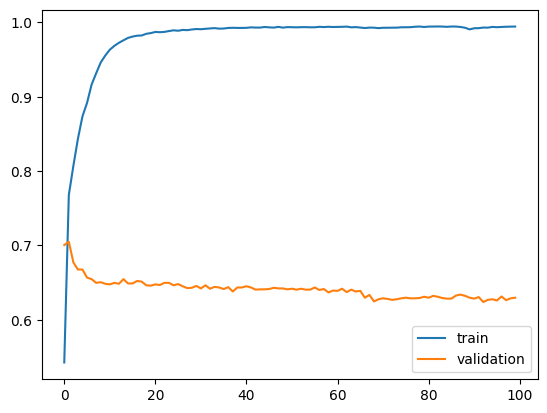

In [35]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()